In [1]:
# Cài đặt kaggle nếu chưa có
!pip install -q kaggle

# Upload file kaggle.json (chọn file từ máy của bạn)
from google.colab import files
files.upload()

# Tạo thư mục ~/.kaggle và di chuyển file kaggle.json vào đó
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# -------------------------------
# 1. Tải dữ liệu ISIC 2016
!kaggle datasets download -d mahmudulhasantasin/isic-2016-original-dataset
!unzip -q isic-2016-original-dataset.zip -d isic2016

# -------------------------------
# 2. Tải dữ liệu HAM10000
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d HAM10000

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mahmudulhasantasin/isic-2016-original-dataset
License(s): CC0-1.0
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
import os

def check_missing_masks(image_dir, mask_dir, img_ext=".jpg", mask_suffix="_Segmentation.png"):
    """
    Duyệt qua các file ảnh trong image_dir và kiểm tra xem file mask tương ứng trong mask_dir có tồn tại không.
    Với mỗi file ảnh, tên file mask được tạo theo quy tắc: thay thế phần mở rộng của ảnh bằng mask_suffix.

    Ví dụ: "ISIC_0000396.jpg" -> "ISIC_0000396_segmentation.png"

    Trả về danh sách các tuple (img_file, mask_file) cho những file thiếu mask.
    """
    missing = []
    # Lấy danh sách các file ảnh có định dạng img_ext
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(img_ext)])

    for img_file in image_files:
        mask_file = img_file.replace(img_ext, mask_suffix)
        mask_path = os.path.join(mask_dir, mask_file)
        if not os.path.exists(mask_path):
            missing.append((img_file, mask_file))
    return missing

# Đường dẫn đến thư mục chứa ảnh và mask (chỉnh sửa cho phù hợp với cấu trúc của bạn)
image_dir = "isic2016/isic 2016/ISBI2016_ISIC_Part1_Training_Data"
mask_dir  = "isic2016/isic 2016/ISBI2016_ISIC_Part1_Training_GroundTruth"

missing_masks = check_missing_masks(image_dir, mask_dir)

if missing_masks:
    print("Các file mask bị thiếu:")
    for img_file, mask_file in missing_masks:
        print(f"Ảnh: {img_file} -> Mask cần có: {mask_file}")
else:
    print("Tất cả các file mask đã có!")

Tất cả các file mask đã có!


In [4]:
class ISIC2016Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask

        # Lấy danh sách file ảnh
        self.image_files = sorted(os.listdir(image_dir))
        # Lọc bỏ file không phải ảnh
        valid_ext = (".jpg", ".png", ".jpeg")
        self.image_files = [f for f in self.image_files if f.lower().endswith(valid_ext)]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)

        # Giả sử groundtruth có dạng "xxx.jpg -> xxx_Segmentation.png"
        mask_file = img_file.replace(".jpg", "_Segmentation.png")
        # mask_file = img_file.replace(".jpg", "_GroundTruth.png") # nếu tên file groundtruth khác

        mask_path = os.path.join(self.mask_dir, mask_file)

        # Đọc ảnh
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # ground truth dạng grayscale

        # Transform
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        # Chuyển mask > 0 thành 1, còn lại 0
        mask = (mask > 0).float()
        return image, mask

# Tạo transform cho ảnh + mask
transform_image_seg = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
transform_mask_seg = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Đường dẫn thư mục
train_image_dir = "isic2016/isic 2016/ISBI2016_ISIC_Part1_Training_Data"
train_mask_dir  = "isic2016/isic 2016/ISBI2016_ISIC_Part1_Training_GroundTruth"

# Tạo dataset
dataset_seg = ISIC2016Dataset(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    transform_image=transform_image_seg,
    transform_mask=transform_mask_seg
)

print("Số mẫu segmentation:", len(dataset_seg))

# Chia train/val/test
total_size_seg = len(dataset_seg)
train_size_seg = int(0.7 * total_size_seg)
val_size_seg = int(0.15 * total_size_seg)
test_size_seg = total_size_seg - train_size_seg - val_size_seg

train_dataset_seg, val_dataset_seg, test_dataset_seg = random_split(
    dataset_seg, [train_size_seg, val_size_seg, test_size_seg]
)

batch_size = 32
train_loader_seg = DataLoader(train_dataset_seg, batch_size=batch_size, shuffle=True)
val_loader_seg   = DataLoader(val_dataset_seg,   batch_size=batch_size, shuffle=False)
test_loader_seg  = DataLoader(test_dataset_seg,  batch_size=batch_size, shuffle=False)

Số mẫu segmentation: 900


[Seg] Epoch 1/50 | Train Loss: 0.6153 | Val Loss: 0.5269
[Seg] Epoch 2/50 | Train Loss: 0.5030 | Val Loss: 0.4522
[Seg] Epoch 3/50 | Train Loss: 0.4442 | Val Loss: 0.4391
[Seg] Epoch 4/50 | Train Loss: 0.4350 | Val Loss: 0.3976
[Seg] Epoch 5/50 | Train Loss: 0.4115 | Val Loss: 0.4017
[Seg] Epoch 6/50 | Train Loss: 0.4043 | Val Loss: 0.3959
[Seg] Epoch 7/50 | Train Loss: 0.3906 | Val Loss: 0.4301
[Seg] Epoch 8/50 | Train Loss: 0.4429 | Val Loss: 0.4154
[Seg] Epoch 9/50 | Train Loss: 0.4233 | Val Loss: 0.3955
[Seg] Epoch 10/50 | Train Loss: 0.4021 | Val Loss: 0.3868
[Seg] Epoch 11/50 | Train Loss: 0.3928 | Val Loss: 0.3769
[Seg] Epoch 12/50 | Train Loss: 0.4032 | Val Loss: 0.3866
[Seg] Epoch 13/50 | Train Loss: 0.3964 | Val Loss: 0.3736
[Seg] Epoch 14/50 | Train Loss: 0.4135 | Val Loss: 0.4209
[Seg] Epoch 15/50 | Train Loss: 0.4066 | Val Loss: 0.3792
[Seg] Epoch 16/50 | Train Loss: 0.3891 | Val Loss: 0.3832
[Seg] Epoch 17/50 | Train Loss: 0.3872 | Val Loss: 0.3772
[Seg] Epoch 18/50 | Tra

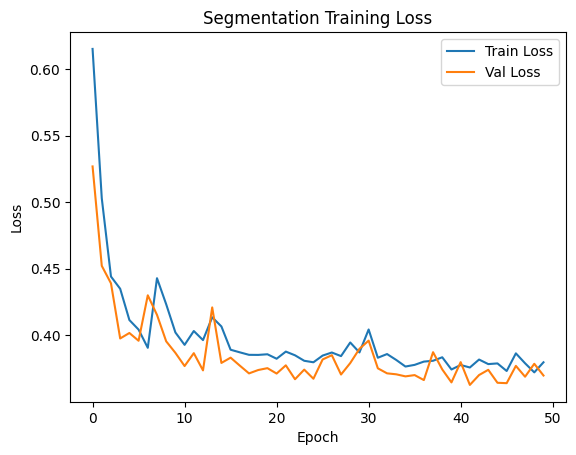

In [5]:
# Định nghĩa UNet
# Định nghĩa một lớp DoubleConv (2 lớp Conv)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Định nghĩa mô hình UNet
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        # Encoder: Các lớp mã hóa (Downsampling)
        self.inc = DoubleConv(n_channels, 64)  # Lớp đầu vào
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))

        # Decoder: Các lớp giải mã (Upsampling)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)

        # Lớp đầu ra (Output Layer)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder (Mã hóa)
        x1 = self.inc(x)  # Lớp đầu vào
        # Sau DoubleConv: (1, 64, 256, 256)

        x2 = self.down1(x1)
        # Sau down1: (1, 128, 128, 128)

        x3 = self.down2(x2)
        # Sau down2: (1, 256, 64, 64)

        x4 = self.down3(x3)
        # Sau down3: (1, 512, 32, 32)

        # Decoder (Giải mã)
        x = self.up1(x4)
        # Sau up1: (1, 256, 64, 64)

        x = torch.cat([x, x3], dim=1)  # Concatenate skip connection
        # Sau concatenation: (1, 768, 64, 64)

        x = self.conv1(x)
        # Sau conv1: (1, 256, 64, 64)

        x = self.up2(x)
        # Sau up2: (1, 128, 128, 128)

        x = torch.cat([x, x2], dim=1)  # Concatenate skip connection
        # Sau concatenation: (1, 384, 128, 128)

        x = self.conv2(x)
        # Sau conv2: (1, 128, 128, 128)

        x = self.up3(x)
        # Sau up3: (1, 64, 256, 256)

        x = torch.cat([x, x1], dim=1)  # Concatenate skip connection
        # Sau concatenation: (1, 128, 256, 256)

        x = self.conv3(x)
        # Sau conv3: (1, 64, 256, 256)

        # Output segmentation map
        logits = self.outc(x)
        # Kết quả phân đoạn: (1, 1, 256, 256)

        return logits

# Khởi tạo mô hình
model_seg = UNet(n_channels=3, n_classes=1).to(device)
criterion_seg = nn.BCEWithLogitsLoss()
optimizer_seg = optim.Adam(model_seg.parameters(), lr=1e-3)

# Training loop
num_epochs_seg = 50
train_losses_seg = []
val_losses_seg = []

for epoch in range(num_epochs_seg):
    # --- Train ---
    model_seg.train()
    running_loss = 0.0
    for images, masks in train_loader_seg:
        images, masks = images.to(device), masks.to(device)
        optimizer_seg.zero_grad()
        outputs = model_seg(images)
        loss = criterion_seg(outputs, masks)
        loss.backward()
        optimizer_seg.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / train_size_seg
    train_losses_seg.append(epoch_loss)

    # --- Validation ---
    model_seg.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader_seg:
            images, masks = images.to(device), masks.to(device)
            outputs = model_seg(images)
            loss = criterion_seg(outputs, masks)
            running_val_loss += loss.item() * images.size(0)
    epoch_val_loss = running_val_loss / val_size_seg
    val_losses_seg.append(epoch_val_loss)

    print(f"[Seg] Epoch {epoch+1}/{num_epochs_seg} | "
          f"Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Lưu model segmentation
torch.save(model_seg.state_dict(), "model_segmentation.pth")
print("Saved segmentation model -> model_segmentation.pth")

# Vẽ biểu đồ Loss
plt.figure()
plt.plot(range(num_epochs_seg), train_losses_seg, label="Train Loss")
plt.plot(range(num_epochs_seg), val_losses_seg, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Segmentation Training Loss")
plt.legend()
plt.show()

In [6]:
# Tạo thư mục "all_images" nếu chưa có
!mkdir -p HAM10000/all_images

# Copy toàn bộ ảnh *.jpg từ 4 thư mục vào "all_images"
!cp HAM10000/HAM10000_images_part_1/*.jpg HAM10000/all_images/ 2>/dev/null
!cp HAM10000/HAM10000_images_part_2/*.jpg HAM10000/all_images/ 2>/dev/null
!cp HAM10000/ham10000_images_part_1/*.jpg HAM10000/all_images/ 2>/dev/null
!cp HAM10000/ham10000_images_part_2/*.jpg HAM10000/all_images/ 2>/dev/null

# Kiểm tra số lượng ảnh sau khi gộp
print("Số ảnh sau khi gộp:", len(os.listdir("HAM10000/all_images")))

Số ảnh sau khi gộp: 10015


In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("HAM10000/HAM10000_metadata.csv")
print(df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')


In [9]:
# Định nghĩa dataset cho HAM10000
class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Lấy danh sách các lớp (dx) và gán index
        self.classes = sorted(self.annotations["dx"].unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        # Dùng "image_id" thay vì "image"
        img_id = row["image_id"]

        # Thêm ".jpg" nếu file thực tế trong folder là "ISIC_xxxxxxx.jpg"
        img_name = img_id + ".jpg"

        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[row["dx"]]  # Lấy chỉ số lớp tương ứng

        if self.transform:
            image = self.transform(image)
        return image, label


transform_cls = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_cls = HAM10000Dataset(
    csv_file="HAM10000/HAM10000_metadata.csv",
    img_dir="HAM10000/all_images",
    transform=transform_cls
)

# Kiểm tra số lượng mẫu
print("Number of classification images:", len(dataset_cls))

# Chia train/val/test
total_size_cls = len(dataset_cls)
train_size_cls = int(0.7 * total_size_cls)
val_size_cls = int(0.15 * total_size_cls)
test_size_cls = total_size_cls - train_size_cls - val_size_cls

train_dataset_cls, val_dataset_cls, test_dataset_cls = random_split(dataset_cls, [train_size_cls, val_size_cls, test_size_cls])
batch_size = 32

train_loader_cls = DataLoader(train_dataset_cls, batch_size=batch_size, shuffle=True)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=batch_size, shuffle=False)
test_loader_cls = DataLoader(test_dataset_cls, batch_size=batch_size, shuffle=False)

Number of classification images: 10015


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Multi-class Epoch 1/50 | Train Loss: 0.8065 | Train Acc: 0.7151 | Val Loss: 0.8576 | Val Acc: 0.6957
Multi-class Epoch 2/50 | Train Loss: 0.6834 | Train Acc: 0.7485 | Val Loss: 0.6746 | Val Acc: 0.7497
Multi-class Epoch 3/50 | Train Loss: 0.6350 | Train Acc: 0.7622 | Val Loss: 0.7819 | Val Acc: 0.7557
Multi-class Epoch 4/50 | Train Loss: 0.6496 | Train Acc: 0.7596 | Val Loss: 0.7426 | Val Acc: 0.7364
Multi-class Epoch 5/50 | Train Loss: 0.5866 | Train Acc: 0.7849 | Val Loss: 0.6921 | Val Acc: 0.7597
Multi-class Epoch 6/50 | Train Loss: 0.5519 | Train Acc: 0.7960 | Val Loss: 1.1334 | Val Acc: 0.5679
Multi-class Epoch 7/50 | Train Loss: 0.5039 | Train Acc: 0.8116 | Val Loss: 0.8772 | Val Acc: 0.7264
Multi-class Epoch 8/50 | Train Loss: 0.5312 | Train Acc: 0.8021 | Val Loss: 0.6996 | Val Acc: 0.7557
Multi-class Epoch 9/50 | Train Loss: 0.4646 | Train Acc: 0.8290 | Val Loss: 0.7683 | Val Acc: 0.7137
Multi-class Epoch 10/50 | Train Loss: 0.4572 | Train Acc: 0.8335 | Val Loss: 0.7501 | Val A

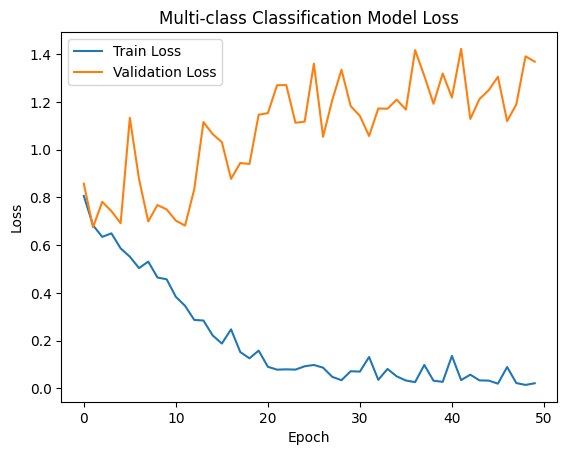

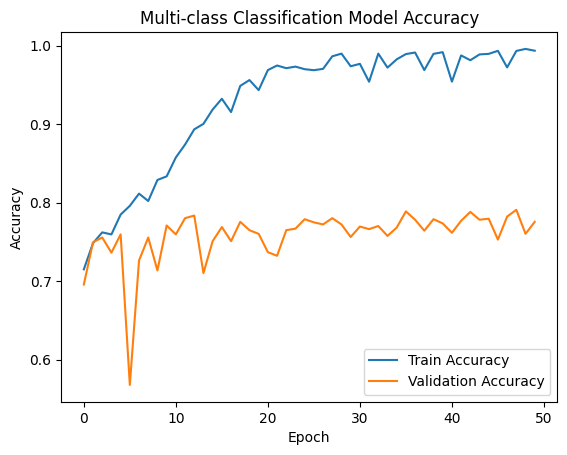

In [10]:
# Khởi tạo mô hình ResNet-18
model_cls = models.resnet18(pretrained=True)
num_features = model_cls.fc.in_features
model_cls.fc = nn.Linear(num_features, len(dataset_cls.classes))
model_cls = model_cls.to(device)

# Định nghĩa loss function và optimizer
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(model_cls.parameters(), lr=1e-3)

num_epochs_cls = 50
train_losses_cls = []
val_losses_cls = []
train_acc_cls = []
val_acc_cls = []

for epoch in range(num_epochs_cls):
    model_cls.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_cls:
        images, labels = images.to(device), labels.to(device)

        optimizer_cls.zero_grad()
        outputs = model_cls(images)
        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer_cls.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / train_size_cls
    epoch_acc = correct / total
    train_losses_cls.append(epoch_loss)
    train_acc_cls.append(epoch_acc)

    # Đánh giá trên tập val
    model_cls.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader_cls:
            images, labels = images.to(device), labels.to(device)
            outputs = model_cls(images)
            loss = criterion_cls(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / val_size_cls
    epoch_val_acc = correct_val / total_val
    val_losses_cls.append(epoch_val_loss)
    val_acc_cls.append(epoch_val_acc)

    print(f"Multi-class Epoch {epoch+1}/{num_epochs_cls} | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

# Đánh giá mô hình trên tập test sau khi huấn luyện
model_cls.eval()
running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader_cls:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cls(images)
        loss = criterion_cls(outputs, labels)

        running_test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = running_test_loss / test_size_cls
test_acc = correct_test / total_test
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# Lưu model multi-class classification
torch.save(model_cls.state_dict(), "model_multiclass.pth")
print("Multi-class classification model saved as model_multiclass.pth")

# Vẽ đồ thị Loss
plt.figure()
plt.plot(range(num_epochs_cls), train_losses_cls, label="Train Loss")
plt.plot(range(num_epochs_cls), val_losses_cls, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Multi-class Classification Model Loss")
plt.legend()
plt.show()

# Vẽ đồ thị Accuracy
plt.figure()
plt.plot(range(num_epochs_cls), train_acc_cls, label="Train Accuracy")
plt.plot(range(num_epochs_cls), val_acc_cls, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Multi-class Classification Model Accuracy")
plt.legend()
plt.show()